Sample

## Load a pre-trained model

In [1]:
from DynGenModels.configs.registered_experiments import Config_JetClass_DeepSets_CondFlowMatch
from DynGenModels.models.experiment import Experiment

path = '../../results/qcd_to_top.ConditionalFlowMatching.DeepSets.2024.02.15_21h28'
cfm = Experiment(Config_JetClass_DeepSets_CondFlowMatch, path=path, DEVICE='cuda:2', NUM_SAMPLING_STEPS=300)
cfm.load()

+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| NAME                | qcd_to_top                                      |
| DATASET             | jetclass                                        |
| DATA_SOURCE         | qcd                                             |
| DATA_TARGET         | top                                             |
| NUM_CONSTITUENTS    | 30                                              |
| FEATURES            | ['pt_rel', 'eta_rel', 'phi_rel']                |
| PREPROCESS          | ['normalize', 'logit_transform', 'standardize'] |
| DIM_INPUT           | 3                                               |
| DEVICE              | cuda:0                                          |
| OPTIMIZER           | Adam                                            |
| LR                  | 0.0001        

2024-02-16 10:48:31.010941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 10:48:32.223659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 10:48:32.230054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 10:48:37.642952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


### Generate samples from model:

In [12]:
from DynGenModels.datamodules.jetclass.dataprocess import PostProcessJetClassData as PostProcessor
cfm.generate_samples(cfm.dataset.source_preprocess[:30000], PostProcessor=PostProcessor)


INFO: neural ODE solver with midpoint method and steps=300


  0%|          | 0/118 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


/tmp/ipykernel_1677484/1515949178.py:51: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/tmp/ipykernel_1677484/1515949178.py:58: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/tmp/ipykernel_1677484/1515949178.py:62: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/tmp/ipykernel_1677484/1515949178.py:64: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(5)


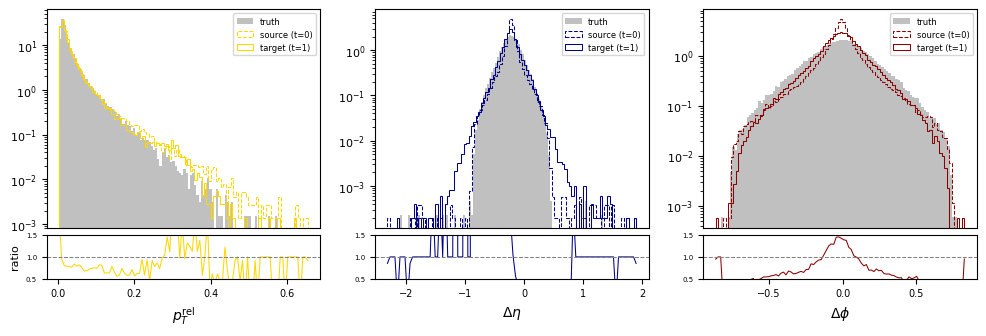

In [ ]:
# from utils import results_plots

results_plots(cfm, save_dir=None, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], figsize=(12,3.5))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_jet_trajectories(trained_model, bins=[50,50,50], figsize=(15,5)):

    x0 = trained_model.pipeline.trajectories[0].reshape(-1,3).detach().cpu().numpy()
    x1 = trained_model.pipeline.trajectories[-1].reshape(-1,3).detach().cpu().numpy()
    target = trained_model.dataset.target[:x0.shape[0]].detach().cpu().numpy()
    
    _, axs = plt.subplots(1, 3, figsize=figsize)
    axs[0].hist(target[..., 0].flatten(), bins=bins[0],log=True, color='darkblue', alpha=0.25,  histtype='stepfilled', label='top', density=True)
    axs[0].hist(x0[..., 0].flatten(), bins=bins[0],log=True, color='darkred', histtype='step', label='qcd source  (t=0)', density=True)
    axs[0].hist(x1[..., 0].flatten(), bins=bins[0],log=True, color='darkblue', histtype='step', label='target (t=1)', density=True)

    axs[1].hist(target[..., 1].flatten(), bins=bins[1],log=True, color='darkblue',  alpha=0.25,  histtype='stepfilled', label='top', density=True)
    axs[1].hist(x0[..., 1].flatten(), bins=bins[1], log=True, color='darkred', histtype='step', label='qcd (source)', density=True)
    axs[1].hist(x1[..., 1].flatten(), bins=bins[0],log=True, color='darkblue', histtype='step', label='target (t=1)', density=True)

    axs[2].hist(target[..., 2].flatten(), bins=bins[2],log=True, color='darkblue',  alpha=0.25,  histtype='stepfilled', label='top', density=True)
    axs[2].hist(x0[..., 2].flatten(), bins=bins[2], log=True, color='darkred', histtype='step', label='source (t=0)', density=True)
    axs[2].hist(x1[..., 2].flatten(), bins=bins[0],log=True, color='darkblue', histtype='step', label='target (t=1)', density=True)

    axs[0].set_xlabel(r'$p_t^{rel}$ constituents')
    axs[1].set_xlabel(r'$\Delta\eta$ constituents')
    axs[2].set_xlabel(r'$\Delta\phi$ constituents')
    axs[0].set_ylabel('density')
    axs[2].legend(loc='upper right', fontsize=7)
    plt.tight_layout()
    plt.show()


def results_plots(trained_model, save_dir=None, features=[r'$p^{\rm rel}_T$', r'$\Delta\eta$', r'$\Delta\phi$'], num_particles=100000, figsize=(10, 3)):
    
    jet0 = trained_model.pipeline.trajectories[0].reshape(-1,3).detach().cpu().numpy()
    jet1 = trained_model.pipeline.trajectories[-1].reshape(-1,3).detach().cpu().numpy()
    jet_true = trained_model.dataset.target[:jet0.shape[0]].detach().cpu().numpy()
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])
    gs.update(hspace=0.05) 
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        h, bins, _ = ax.hist(jet_true[..., idx].flatten()[:num_particles], bins=100, log=True   , color='silver', density=True, label='truth')
        h0, _, _ = ax.hist(jet0[..., idx].flatten()[:num_particles], bins=100, log=True, color=['gold', 'darkblue', 'darkred'][idx], ls='--', histtype='step', density=True, lw=0.75, label='source (t=0)')
        h1, _, _ = ax.hist(jet1[..., idx].flatten()[:num_particles], bins=100, log=True, color=['gold', 'darkblue', 'darkred'][idx], histtype='step', density=True, lw=0.75 , label='target (t=1)')
        ax.set_xticklabels([])
        ax.set_xticks([])
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        ax.legend(fontsize=6)

        # Ratio plot
        ax_ratio = fig.add_subplot(gs[idx + 3])
        ratio = np.divide(h1, h, out=np.ones_like(h), where=h != 0)
        ax_ratio.plot(0.5 * (bins[:-1] + bins[1:]), ratio, color=['gold', 'darkblue', 'darkred'][idx],lw=0.75)
        ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
        ax_ratio.set_xlabel(feature)
        ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
        for tick in ax_ratio.xaxis.get_major_ticks():
            tick.label.set_fontsize(7)
        for tick in ax_ratio.yaxis.get_major_ticks():
            tick.label.set_fontsize(5)  
        if idx == 0:
            ax_ratio.set_ylabel('ratio', fontsize=8)
        ax_ratio.set_yticks([0.5, 1, 1.5])
    if save_dir is not None:
        plt.savefig(save_dir + '/particle_features.pdf')
    plt.show()